In [4]:
import requests
import re
import pandas as pd
import random
from string import ascii_lowercase
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from urllib.request import urlopen
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils import shuffle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preprocessing

In [5]:
# Download NLTK stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text: remove punctuation, stop words, and non-textual elements
# def clean_text(text):
#     # Remove punctuation
#     text = re.sub(r'[^\w\s]', '', text)
#     # Split into words
#     words = text.split()
#     # Remove stop words and non-textual elements
#     cleaned_words = [word for word in words if word.lower() not in stop_words]
#     # strip underscores
#     cleaned_words = [word.strip('_') for word in cleaned_words]
#     # remove numbers
#     cleaned_words = [word for word in cleaned_words if not word.isnumeric()]
#     # remove words that start with numbers
#     cleaned_words = [word for word in cleaned_words if not word[0].isnumeric()]
#     return ' '.join(cleaned_words)

# Function to create the partitions
def split_into_fixed_partitions(text, partitions=200, words_per_partition=100):
    words = text.split()
    partitions = [words[i:i + 100] for i in range(0, len(words), 100)]
    random_partitions = random.sample(partitions, min(200, len(partitions)))

    return random_partitions

def find_start_end(text):
    # Find the start and end of the main text
    start_pattern = r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .+ \*\*\*"
    end_pattern = r"\*\*\* END OF THIS PROJECT GUTENBERG EBOOK .+ \*\*\*"

    start_match = re.search(start_pattern, text)
    end_match = re.search(end_pattern, text)

    start_idx = start_match.end() if start_match else 0
    end_idx = end_match.start() if end_match else len(text)

    return text[start_idx:end_idx]

# def process_book(url, label):
#     # Download the book text from the URL
#     response = requests.get(url)
#     response.encoding = 'utf-8'
#     text = response.text

#     # Extract the main text between start and end markers
#     main_text = find_start_end(text)

#     # Clean the main text
#     cleaned_text = clean_text(main_text)

#     # Extract words from the cleaned text
#     words = cleaned_text.split()

#     # Split words into partitions of 100 and take 200 random partitions
#     partitions = [words[i:i + 100] for i in range(0, len(words), 100)]
#     random_partitions = random.sample(partitions, min(200, len(partitions)))

#     return [(label, ' '.join(partition)) for partition in random_partitions]

def process_book(url):
  raw = urlopen(url).read()

  # convert raw format to string and fetch author name of the book
  string_txt = str(raw)
  author_name_match = re.search(r'Author:?[\w\s;:,\'\"]+',string_txt)
  tokens = word_tokenize(string_txt)
  author_name = author_name_match.group(0)[7:len(author_name_match.group(0))]

  #Remove stop words from the text
  stwrd = stopwords.words('english')
  cleaned_string = [word for word in tokens if word.lower() not in stwrd and word.isalpha()]
  cleaned_string = ' '.join(cleaned_string)

  #removing special characters and escape sequences
  cleaned_string = re.sub(r'\\[^,:;]+|[^\x20-\x7E]+','',cleaned_string)
  new_string = find_start_end(cleaned_string)

  #Split the text into partitions
  partitions = split_into_fixed_partitions(cleaned_string, partitions=200, words_per_partition=100)
  partitions = [{"Words" : ' '.join(part), "Label" : author_name} for part in partitions]
  return partitions

# Updated list of Gutenberg book URLs (Same as before, no change needed here)
# book_urls = [
#     'https://www.gutenberg.org/files/1342/1342-0.txt',  # Pride and Prejudice by Jane Austen
#     'https://www.gutenberg.org/files/768/768-0.txt',    # Wuthering Heights by Emily Brontë
#     'https://www.gutenberg.org/files/1260/1260-0.txt',  # Jane Eyre by Charlotte Brontë
#     'https://www.gutenberg.org/files/1400/1400-0.txt',  # Great Expectations by Charles Dickens
#     'https://www.gutenberg.org/files/145/145-0.txt',    # Middlemarch by George Eliot
#     'https://www.gutenberg.org/files/541/541.txt'       # The Age of Innocence by Edith Wharton
# ]

# book_authors = ["Jane Austen", "Emily Bronte", "Charlotte Bronte", "Charles Dickens",  "George Eliot", "Edith Wharton"]
book_urls = [
    'https://www.gutenberg.org/cache/epub/1342/pg1342.txt',  # Pride and Prejudice by Jane Austen
    'https://www.gutenberg.org/cache/epub/768/pg768.txt',    # Wuthering Heights by Emily Brontë
    'https://www.gutenberg.org/cache/epub/1260/pg1260.txt',    # Jane Eyre: An Autobiography by Charlotte Brontë
    'https://www.gutenberg.org/cache/epub/1400/pg1400.txt',    # Great Expectations Charles Dickens
    'https://www.gutenberg.org/cache/epub/145/pg145.txt',      # Middlemarch by George Eliot
    'https://www.gutenberg.org/cache/epub/541/pg541.txt'       # The Age of Innocence by Edith Wharton
]


# Process all books
all_partitions = []

# for url, label in zip(book_urls, book_authors):
for url in book_urls:
    book_partitions = process_book(url)
    all_partitions.extend(book_partitions)

# Convert to DataFrame
partition_df = pd.DataFrame(all_partitions)

# Serialize DataFrame to CSV
partition_df.to_csv('book_partitions_cleaned.csv', index=False)

partition_df = shuffle(partition_df, random_state=69)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
partition_df.head()

,Words,Label
543,must care care Janet would try sightless block...,Charlotte Bront
1149,could plucked grew venerated family tree peopl...,Edith Wharton
653,probe wounds use Pip use asked eagerness heari...,Charles Dickens
934,Lydgate feeling surprised little peculiarity t...,George Eliot
668,improve two ways sort seeing Biddy observant l...,Charles Dickens


# Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.multiclass import OneVsRestClassifier

In [11]:
model_objs = [
    OneVsRestClassifier(SVC(kernel="rbf")),
    RandomForestClassifier(),
    OneVsRestClassifier(GaussianNB()),
    KNeighborsClassifier(),
    OneVsRestClassifier(SGDClassifier()),
    DecisionTreeClassifier(),
    OneVsRestClassifier(AdaBoostClassifier()),
    OneVsRestClassifier(XGBClassifier(random_state=69))
    ]


model_names = [
    "Gaussian SVC",
    "RandomForestClassifier",
    "Naive Bayes",
    "KNeighborsClassifier",
    "SGDClassifier",
    "DecisionTreeClassifier",
    "AdaBoostClassifier",
    "XGBClassifier",
]

In [ ]:
partition_df.shape

(1200, 2)

MODEL: Gaussian SVC
Average Accuracy: 0.6108333333333335
Average Precision: 0.6148870138370577
Average Recall: 0.9978174603174603
Average F1: 0.7339329875509623
Average ROC AUC: 0.8072768235835286

MODEL: RandomForestClassifier
Average Accuracy: 0.5525
Average Precision: 0.5555705007083838
Average Recall: 0.9764456919891703
Average F1: 0.687998028074587
Average ROC AUC: 0.7765425748310669

MODEL: Naive Bayes
Average Accuracy: 0.45333333333333325
Average Precision: 0.45953308296874057
Average Recall: 0.9598625448625449
Average F1: 0.5946659230414661
Average ROC AUC: 0.7279368219705697

MODEL: KNeighborsClassifier
Average Accuracy: 0.5575000000000001
Average Precision: 0.5577861146639413
Average Recall: 0.9041746546237196
Average F1: 0.6344818786511942
Average ROC AUC: 0.7690292061660262

MODEL: SGDClassifier
Average Accuracy: 0.7683333333333333
Average Precision: 0.7895151924520557
Average Recall: 0.9316820565448072
Average F1: 0.849707728021803
Average ROC AUC: 0.8891850800018858

MODE

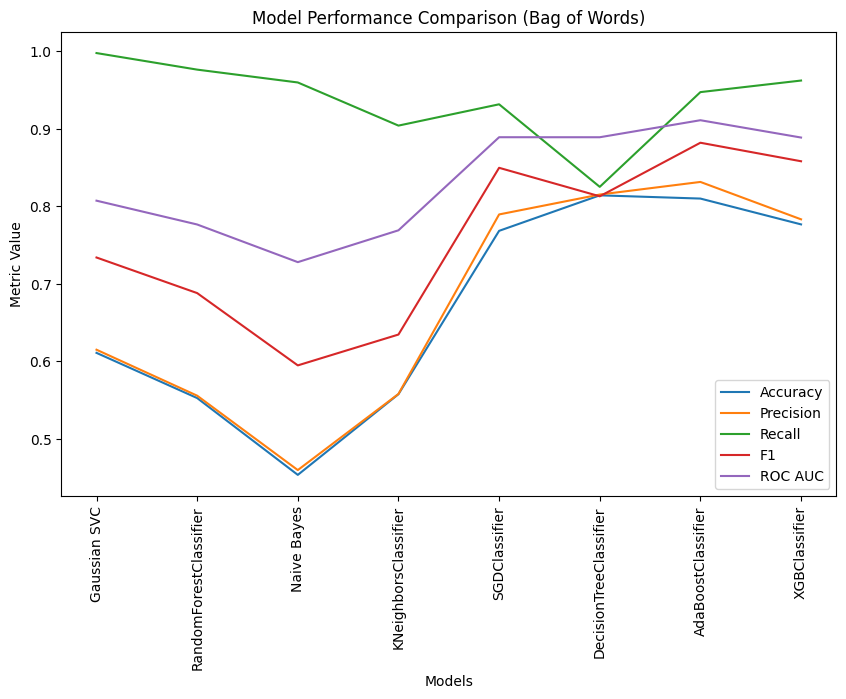

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

kf = KFold(n_splits=10, shuffle=True, random_state=69)
onehot_encoder = OneHotEncoder(sparse=False)

# Lists to store metric values for each model
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

for m_obj, m_name in zip(model_objs, model_names):
  acc_sum = 0
  precision_sum = 0
  recall_sum = 0
  f1_sum = 0
  roc_auc_sum = 0
  for train_index,test_index in kf.split(partition_df):
    train_data = partition_df.iloc[train_index]
    test_data = partition_df.iloc[test_index]
    X_train = train_data.drop(['Label'], axis=1)
    y_train = train_data['Label']
    X_test = test_data.drop(['Label'], axis=1)
    y_test = test_data['Label']
    # One-hot encoding for the label
    y_train_onehot = onehot_encoder.fit_transform(train_data[['Label']])
    y_test_onehot = onehot_encoder.transform(test_data[['Label']])

    y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
    y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

    X_train_bow = bow_vectorizer.fit_transform(X_train['Words'])
    X_test_bow = bow_vectorizer.transform(X_test['Words'])
    X_train_bow = pd.DataFrame(X_train_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
    X_test_bow = pd.DataFrame(X_test_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

    m_obj.fit(X_train_bow, y_train_df),
    y_pred = m_obj.predict(X_test_bow)
    acc = accuracy_score(y_pred, y_test_df)
    precision = precision_score(y_pred, y_test_df, average='macro')
    recall = recall_score(y_pred, y_test_df, average='macro')
    f1 = f1_score(y_pred, y_test_df, average='macro')
    roc_auc = roc_auc_score(y_test_df, y_pred,  average='macro')

    acc_sum+=acc
    precision_sum += precision
    recall_sum += recall
    f1_sum += f1
    roc_auc_sum += roc_auc

  # Calculate average metric values for the model
  avg_acc = acc_sum / 10
  avg_precision = precision_sum / 10
  avg_recall = recall_sum / 10
  avg_f1 = f1_sum / 10
  avg_roc_auc = roc_auc_sum / 10

  # Append the average metric values to the respective lists
  accuracy_list.append(avg_acc)
  precision_list.append(avg_precision)
  recall_list.append(avg_recall)
  f1_list.append(avg_f1)
  roc_auc_list.append(avg_roc_auc)


  print("MODEL: {}".format(m_name))
  print("Average Accuracy: {}".format(acc_sum/10))
  print("Average Precision: {}".format(precision_sum/10))
  print("Average Recall: {}".format(recall_sum/10))
  print("Average F1: {}".format(f1_sum/10))
  print("Average ROC AUC: {}".format(roc_auc_sum/10))
  print()


# Plotting the graph
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.3)

for i, metric_list in enumerate([accuracy_list, precision_list, recall_list, f1_list, roc_auc_list]):
    plt.plot(model_names, metric_list, label=metrics[i])


plt.title('Model Performance Comparison (Bag of Words)')
plt.xlabel('Models')

# Rotate model names vertically
plt.xticks(rotation=90, ha='center')

plt.ylabel('Metric Value')
plt.legend()
plt.show()

# TF IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

MODEL: Gaussian SVC
Average Accuracy: 0.45583333333333326
Average Precision: 0.46126471299511085
Average Recall: 0.95
Average F1: 0.5897814833471069
Average ROC AUC: 0.7306323564975553

MODEL: RandomForestClassifier
Average Accuracy: 0.5016666666666667
Average Precision: 0.5054810168236381
Average Recall: 0.9861484891919675
Average F1: 0.6438874622805366
Average ROC AUC: 0.7521562512273726

MODEL: Naive Bayes
Average Accuracy: 0.30666666666666664
Average Precision: 0.30899754201476054
Average Recall: 0.917504997725586
Average F1: 0.44131014379146893
Average ROC AUC: 0.6525881453447125

MODEL: KNeighborsClassifier
Average Accuracy: 0.8441666666666666
Average Precision: 0.8414886587953342
Average Recall: 0.9586770392548314
Average F1: 0.8886717383146359
Average ROC AUC: 0.9172660234365108

MODEL: SGDClassifier
Average Accuracy: 0.8241666666666667
Average Precision: 0.8279949053076547
Average Recall: 0.9771473161914338
Average F1: 0.8898339228398916
Average ROC AUC: 0.9120974674587299

MO

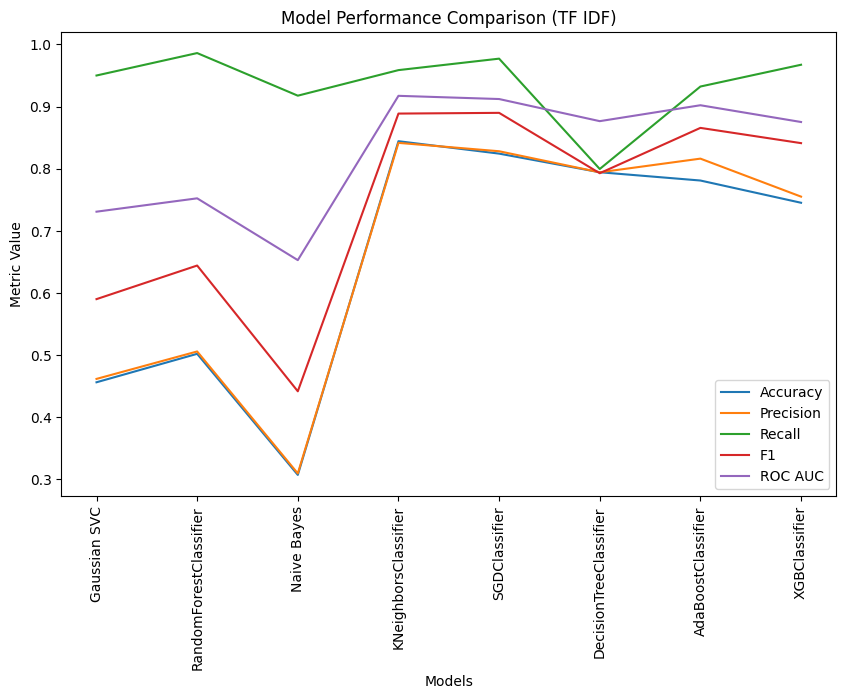

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

kf = KFold(n_splits=10, shuffle=True, random_state=69)
onehot_encoder = OneHotEncoder(sparse=False)

# Lists to store metric values for each model
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []


for m_obj, m_name in zip(model_objs, model_names):
  acc_sum = 0
  precision_sum = 0
  recall_sum = 0
  f1_sum = 0
  roc_auc_sum = 0
  for train_index,test_index in kf.split(partition_df):
    train_data = partition_df.iloc[train_index]
    test_data = partition_df.iloc[test_index]
    X_train = train_data.drop(['Label'], axis=1)
    y_train = train_data['Label']
    X_test = test_data.drop(['Label'], axis=1)
    y_test = test_data['Label']
    # One-hot encoding for the label
    y_train_onehot = onehot_encoder.fit_transform(train_data[['Label']])
    y_test_onehot = onehot_encoder.transform(test_data[['Label']])

    y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
    y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['Words'])
    X_test_tfidf = tfidf_vectorizer.transform(X_test['Words'])
    X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    m_obj.fit(X_train_tfidf, y_train_df),
    y_pred = m_obj.predict(X_test_tfidf)
    acc = accuracy_score(y_pred, y_test_df)
    precision = precision_score(y_pred, y_test_df, average='macro')
    recall = recall_score(y_pred, y_test_df, average='macro')
    f1 = f1_score(y_pred, y_test_df, average='macro')
    roc_auc = roc_auc_score(y_test_df, y_pred, average='macro')

    acc_sum+=acc
    precision_sum += precision
    recall_sum += recall
    f1_sum += f1
    roc_auc_sum += roc_auc

  # Calculate average metric values for the model
  avg_acc = acc_sum / 10
  avg_precision = precision_sum / 10
  avg_recall = recall_sum / 10
  avg_f1 = f1_sum / 10
  avg_roc_auc = roc_auc_sum / 10

  # Append the average metric values to the respective lists
  accuracy_list.append(avg_acc)
  precision_list.append(avg_precision)
  recall_list.append(avg_recall)
  f1_list.append(avg_f1)
  roc_auc_list.append(avg_roc_auc)

  print("MODEL: {}".format(m_name))
  print("Average Accuracy: {}".format(acc_sum/10))
  print("Average Precision: {}".format(precision_sum/10))
  print("Average Recall: {}".format(recall_sum/10))
  print("Average F1: {}".format(f1_sum/10))
  print("Average ROC AUC: {}".format(roc_auc_sum/10))
  print()

  # Plotting the graph
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.3)

for i, metric_list in enumerate([accuracy_list, precision_list, recall_list, f1_list, roc_auc_list]):
    plt.plot(model_names, metric_list, label=metrics[i])


plt.title('Model Performance Comparison (TF IDF)')
plt.xlabel('Models')

# Rotate model names vertically
plt.xticks(rotation=90, ha='center')

plt.ylabel('Metric Value')
plt.legend()
plt.show()

# Word embedding

In [ ]:
import numpy as np

glove_file_path= 'glove.6B.50d.txt'

# Function to load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings into the dictionary
glove_embeddings = load_glove_embeddings(glove_file_path)

MODEL: Gaussian SVC
Average Accuracy: 0.021666666666666664
Average Precision: 0.021928873686226626
Average Recall: 0.16666666666666669
Average F1: 0.038082214560856045
Average ROC AUC: 0.5109644368431134

MODEL: RandomForestClassifier
Average Accuracy: 0.10500000000000001
Average Precision: 0.10769074385429211
Average Recall: 0.6333134920634921
Average F1: 0.16571305965233188
Average ROC AUC: 0.5520057862333128

MODEL: Naive Bayes
Average Accuracy: 0.1525
Average Precision: 0.6416696231982273
Average Recall: 0.37033068471574837
Average F1: 0.4632197675084672
Average ROC AUC: 0.7120286298960848

MODEL: KNeighborsClassifier
Average Accuracy: 0.27416666666666667
Average Precision: 0.2738055115602172
Average Recall: 0.5722764148189844
Average F1: 0.34988957311864294
Average ROC AUC: 0.6183162238511354

MODEL: SGDClassifier
Average Accuracy: 0.3158333333333333
Average Precision: 0.37580171553024
Average Recall: 0.657356052498435
Average F1: 0.41836066468043454
Average ROC AUC: 0.66049485898

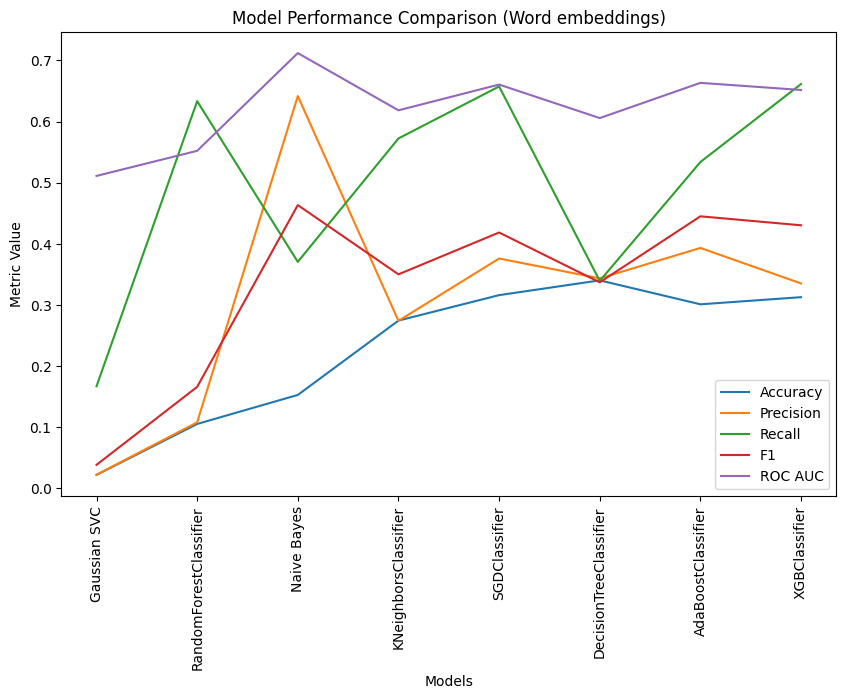

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Assuming you have defined 'model' and 'names' somewhere in your code

kf = KFold(n_splits=10, shuffle=True, random_state=69)
onehot_encoder = OneHotEncoder(sparse=False)

# Lists to store metric values for each model
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

for m_obj, m_name in zip(model_objs, model_names):
    acc_sum = 0
    precision_sum = 0
    recall_sum = 0
    f1_sum = 0
    roc_auc_sum = 0

    for train_index, test_index in kf.split(partition_df):
        train_data = partition_df.iloc[train_index]
        test_data = partition_df.iloc[test_index]
        X_train = train_data['Words']
        y_train = train_data['Label']
        X_test = test_data['Words']
        y_test = train_data['Label']

        # Create document embeddings using GloVe
        X_train_glove = np.array([np.mean([glove_embeddings.get(word, np.zeros(50)) for word in sentence.split()], axis=0) for sentence in X_train])
        X_test_glove = np.array([np.mean([glove_embeddings.get(word, np.zeros(50)) for word in sentence.split()], axis=0) for sentence in X_test])

        # One-hot encoding for the label
        y_train_onehot = onehot_encoder.fit_transform(train_data[['Label']])
        y_test_onehot = onehot_encoder.transform(test_data[['Label']])
        y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
        y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

        #Model Training and Prediction
        m_obj.fit(X_train_glove, y_train_df)
        y_pred = m_obj.predict(X_test_glove)

        # Compute Evaluation Metrics
        acc = accuracy_score(y_pred, y_test_df)
        precision = precision_score(y_pred, y_test_df, average='macro')
        recall = recall_score(y_pred, y_test_df, average='macro')
        f1 = f1_score(y_pred, y_test_df, average='macro')
        roc_auc = roc_auc_score(y_test_df, y_pred, average='macro')

        acc_sum += acc
        precision_sum += precision
        recall_sum += recall
        f1_sum += f1
        roc_auc_sum += roc_auc

    # Calculate average metric values for the model
    avg_acc = acc_sum / 10
    avg_precision = precision_sum / 10
    avg_recall = recall_sum / 10
    avg_f1 = f1_sum / 10
    avg_roc_auc = roc_auc_sum / 10

    # Append the average metric values to the respective lists
    accuracy_list.append(avg_acc)
    precision_list.append(avg_precision)
    recall_list.append(avg_recall)
    f1_list.append(avg_f1)
    roc_auc_list.append(avg_roc_auc)

    print("MODEL: {}".format(m_name))
    print("Average Accuracy: {}".format(avg_acc))
    print("Average Precision: {}".format(avg_precision))
    print("Average Recall: {}".format(avg_recall))
    print("Average F1: {}".format(avg_f1))
    print("Average ROC AUC: {}".format(avg_roc_auc))
    print()

# Plotting the graph
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.3)

for i, metric_list in enumerate([accuracy_list, precision_list, recall_list, f1_list, roc_auc_list]):
    plt.plot(model_names, metric_list, label=metrics[i])


plt.title('Model Performance Comparison (Word embeddings)')
plt.xlabel('Models')

# Rotate model names vertically
plt.xticks(rotation=90, ha='center')

plt.ylabel('Metric Value')
plt.legend()
plt.show()

# N-Gram


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=5, shuffle=True, random_state=69)
onehot_encoder = OneHotEncoder(sparse_output=False)

# Lists to store metric values for each model
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

for m_obj, m_name in zip(model_objs, model_names):
  acc_sum = 0
  precision_sum = 0
  recall_sum = 0
  f1_sum = 0
  roc_auc_sum = 0
  for train_index,test_index in kf.split(partition_df):
    train_set, test_set = partition_df.iloc[train_index], partition_df.iloc[test_index]

    X_train = train_set.drop(['Label'], axis=1)
    y_train = train_set['Label']
    X_test = test_set.drop(['Label'], axis=1)
    y_test = test_set['Label']

    min_n, max_n = 1, 2  # Example: Trying n-grams from 1 to 2
    ngram_range_values = [(i, j) for i in range(min_n, max_n + 1) for j in range(i, max_n + 1)]

    # One-hot encoding for the label
    y_train_onehot = onehot_encoder.fit_transform(train_set[['Label']])
    y_test_onehot = onehot_encoder.transform(test_set[['Label']])


    y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
    y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

    max_acc,max_precision,max_recall,max_f1,max_roc_auc = [-1,-1,-1,-1,-1]

    for ngrams in ngram_range_values:
      vec = CountVectorizer(ngram_range = ngrams)
      X_train_vec = vec.fit_transform(X_train['Words'])
      X_train_vec = pd.DataFrame(X_train_vec.toarray(), columns=vec.get_feature_names_out())
      X_test_vec = vec.transform(X_test['Words'])
      X_test_vec = pd.DataFrame(X_test_vec.toarray(), columns=vec.get_feature_names_out())
      m_obj.fit(X_train_vec,y_train_df)
      y_pred = m_obj.predict(X_test_vec)
      acc = accuracy_score(y_pred, y_test_df)
      precision = precision_score(y_pred, y_test_df, average='macro')
      recall = recall_score(y_pred, y_test_df, average='macro')
      f1 = f1_score(y_test_df, y_pred, average='macro')
      roc_auc = roc_auc_score(y_test_df, y_pred, average='macro')

      max_acc = max(max_acc,acc)
      max_precision = max(max_precision,precision)
      max_recall = max(max_recall,recall)
      max_f1 = max(max_f1,f1)
      max_roc_auc = max(max_roc_auc,roc_auc)

    acc_sum+=max_acc
    precision_sum += max_precision
    recall_sum += max_recall
    f1_sum += max_f1
    roc_auc_sum += max_roc_auc

  # Append the average metric values to the respective lists
  accuracy_list.append(acc_sum/10)
  precision_list.append(precision_sum/10)
  recall_list.append(recall_sum/10)
  f1_list.append(f1_sum/10)
  roc_auc_list.append(roc_auc_sum/10)

  print("MODEL: {}".format(m_name))
  print("Average Accuracy: {}".format(acc_sum/10))
  print("Average Precision: {}".format(precision_sum/10))
  print("Average Recall: {}".format(recall_sum/10))
  print("Average F1: {}".format(f1_sum/10))
  print("Average ROC AUC: {}".format(roc_auc_sum/10))
  print()

# Plotting the graph
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

plt.figure(figsize=(10, 8))
plt.subplots_adjust(bottom=0.3)

for i, metric_list in enumerate([accuracy_list, precision_list, recall_list, f1_list, roc_auc_list]):
    plt.plot(model_names, metric_list, label=metrics[i])


plt.title('Model Performance Comparison (N gram)')
plt.xlabel('Models')

# Rotate model names vertically
plt.xticks(rotation=90, ha='center')

plt.ylabel('Metric Value')
plt.legend()
plt.show()

MODEL: Gaussian SVC
Average Accuracy: 0.4416666666666667
Average Precision: 0.3450710678210678
Average Recall: 0.738181818181818
Average F1: 0.44972377100024163
Average ROC AUC: 0.6723314522778808

MODEL: RandomForestClassifier
Average Accuracy: 0.5783333333333333
Average Precision: 0.5044388389388389
Average Recall: 0.9983333333333334
Average F1: 0.6343255912511533
Average ROC AUC: 0.7519921467421469

MODEL: Naive Bayes
Average Accuracy: 0.7083333333333334
Average Precision: 0.6688301975801976
Average Recall: 0.9484357864357864
Average F1: 0.7612917485664153
Average ROC AUC: 0.8304553544883377

MODEL: KNeighborsClassifier
Average Accuracy: 0.5716666666666667
Average Precision: 0.5363609168609169
Average Recall: 0.8701533973273105
Average F1: 0.5764667430093128
Average ROC AUC: 0.7507810345948644

MODEL: SGDClassifier
Average Accuracy: 0.7616666666666668
Average Precision: 0.7568030858030859
Average Recall: 0.9463492063492065
Average F1: 0.8163203963817102
Average ROC AUC: 0.8713227706182677

MODEL: DecisionTreeClassifier
Average Accuracy: 0.8133333333333332
Average Precision: 0.8283436285936284
Average Recall: 0.8933379953379953
Average F1: 0.8513696660534691
Average ROC AUC: 0.9020748211414483

MODEL: AdaBoostClassifier
Average Accuracy: 0.8166666666666667
Average Precision: 0.8254561827061828
Average Recall: 0.9362458848341202
Average F1: 0.866681881890403
Average ROC AUC: 0.9053448783448268

MODEL: XGBClassifier
Average Accuracy: 0.7733333333333333
Average Precision: 0.7389045954045954
Average Recall: 0.9799761904761904
Average F1: 0.8288507708228124
Average ROC AUC: 0.8680768009379355

# BERT

In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.25969836 -0.52364445  0.9036142  -0.55134004 -0.88770914  0.9886292
 -0.30357572 -0.00745822 -0.9583914   0.06638025  0.23976119  0.06133483]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.1338202   0.03000332  0.17117347 ... -0.47139746 -0.92813057
   0.51842195]
 [-0.05726065  1.0102304  -0.164846   ... -0.77384204 -0.5603515
   0.07679403]
 [-1.2910262   0.0331322   0.7465316  ... -0.45870095  0.32357264
   0.24169521]
 ...
 [ 0.01642712  0.0605648   0.43864334 ...  0.24693727 -0.2777899
   0.3536233 ]
 [-0.3973329   0.0986197   0.16961995 ...  0.16997036 -0.6732824
   0.42493147]
 [ 0.16625747 -0.19789703 -0.4526961  ...  0.31699604 -0.6168943
   0.11923101]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(128, activation='relu', name='hidden_1')(net)
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.04285008 0.02274035 0.25739798 0.17746463 0.40229428 0.0972527 ]], shape=(1, 6), dtype=float32)


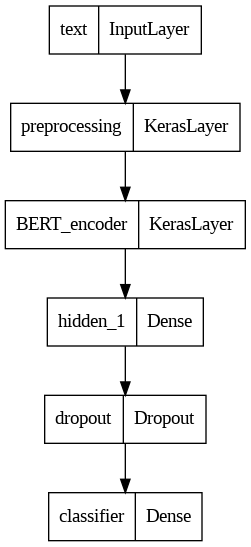

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
X = partition_df.drop(['Label'], axis=1)
y = partition_df['Label']

In [ ]:
partition_df

,Label,Words
43,Jane Austen,good terms anyone always pleased varianceThere...
863,George Eliot,said undertones none us know might mind hope t...
891,George Eliot,rest money refused said Fred biting lip speaki...
279,Emily Bronte,little wretch rousing halfbred bulldog lair co...
365,Emily Bronte,unaccompanied also brought word Catherine ill ...
...,...,...
120,Jane Austen,behaviour sister dinnertime showed admiration ...
369,Emily Bronte,human retorted claim charity gave heart took p...
849,George Eliot,turned Featherstones sticking name em Solomon ...
860,George Eliot,elaborator small explanations important surplu...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
import numpy as np
warnings.filterwarnings('ignore')

onehot_encoder = OneHotEncoder(sparse=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = onehot_encoder.fit_transform(np.array(y_train).reshape(-1,1))
y_test_onehot = onehot_encoder.transform(np.array(y_test).reshape(-1,1))

y_train_df = pd.DataFrame(y_train_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))
y_test_df = pd.DataFrame(y_test_onehot, columns=onehot_encoder.get_feature_names_out(['Label']))

In [ ]:
epochs = 10
optimizer = tf.keras.optimizers.Adam(0.0001)

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
history = classifier_model.fit(X_train,y_train_df, batch_size=128, epochs=epochs, validation_data=(X_test, y_test_df))

Epoch 1/10
8/8 [==============================] - 18s 1s/step - loss: 1.7071 - categorical_accuracy: 0.3250 - val_loss: 1.3749 - val_categorical_accuracy: 0.3750
Epoch 2/10
8/8 [==============================] - 9s 1s/step - loss: 1.2706 - categorical_accuracy: 0.5021 - val_loss: 1.0467 - val_categorical_accuracy: 0.6542
Epoch 3/10
8/8 [==============================] - 7s 931ms/step - loss: 1.0021 - categorical_accuracy: 0.5958 - val_loss: 0.8797 - val_categorical_accuracy: 0.6958
Epoch 4/10
8/8 [==============================] - 9s 1s/step - loss: 0.7385 - categorical_accuracy: 0.7500 - val_loss: 0.6819 - val_categorical_accuracy: 0.7833
Epoch 5/10
8/8 [==============================] - 8s 1s/step - loss: 0.4900 - categorical_accuracy: 0.8417 - val_loss: 0.4975 - val_categorical_accuracy: 0.8458
Epoch 6/10
8/8 [==============================] - 7s 904ms/step - loss: 0.3331 - categorical_accuracy: 0.9042 - val_loss: 0.3928 - val_categorical_accuracy: 0.8792
Epoch 7/10
8/8 [===========

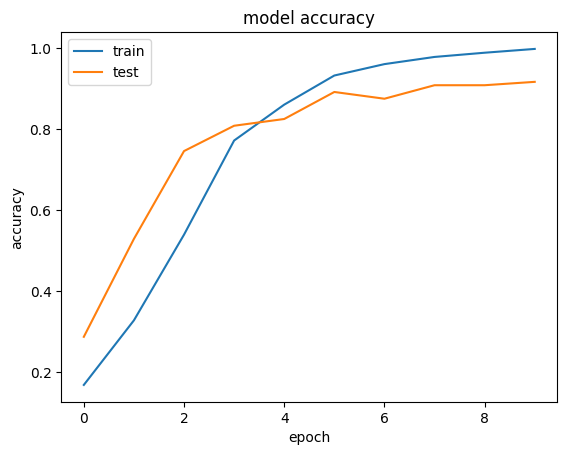

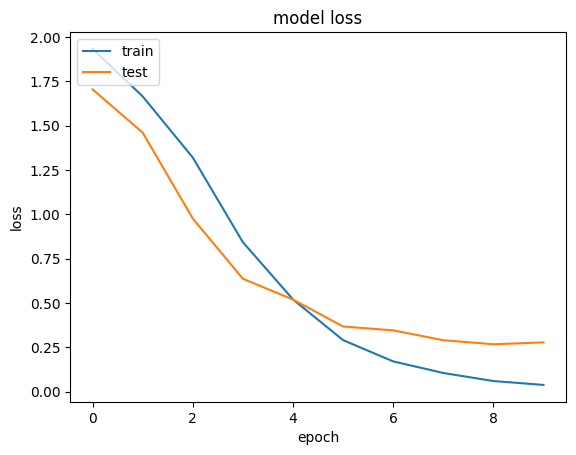

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_pred = to_categorical(np.argmax(classifier_model.predict(X_test), axis=-1))

8/8 [==============================] - 1s 93ms/step


In [ ]:
y_pred

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

acc = accuracy_score(y_pred, y_test_onehot)
precision = precision_score(y_pred, y_test_onehot, average='macro')
recall = recall_score(y_pred, y_test_onehot, average='macro')
f1 = f1_score(y_pred, y_test_onehot, average='macro')
roc_auc = roc_auc_score(y_test_onehot, y_pred, average='macro')

In [ ]:
print("Average Accuracy: {}".format(acc))
print("Average Precision: {}".format(precision))
print("Average Recall: {}".format(recall))
print("Average F1: {}".format(f1))
print("Average ROC AUC: {}".format(roc_auc))

Average Accuracy: 0.9666666666666667
Average Precision: 0.9671211505422033
Average Recall: 0.9674673864147548
Average F1: 0.9670630409050239
Average ROC AUC: 0.9802162238080916


In [ ]:
y_test_label = np.argmax(y_test_onehot, axis=-1)

In [ ]:
y_pred_label = np.argmax(y_pred, axis=-1)

In [ ]:
classifier_model.save('BERT_classifier.h5')

In [ ]:
classifier_model = tf.keras.models.load_model('BERT_classifier.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
y_pred = to_categorical(np.argmax(classifier_model.predict(X_test), axis=-1))

8/8 [==============================] - 1s 84ms/step


In [ ]:
y_pred_label = np.argmax(y_pred, axis=-1)

In [ ]:
np.argmax(y_test_onehot, axis=-1)

array([1, 2, 2, 1, 4, 1, 4, 5, 5, 1, 0, 1, 2, 1, 5, 4, 5, 2, 5, 2, 0, 1,
       2, 2, 3, 4, 1, 0, 3, 1, 1, 0, 3, 4, 3, 3, 1, 3, 4, 3, 4, 0, 0, 4,
       0, 5, 0, 4, 3, 5, 2, 0, 0, 1, 2, 3, 3, 1, 2, 3, 0, 0, 2, 5, 4, 2,
       0, 3, 0, 0, 2, 3, 2, 0, 1, 1, 5, 1, 2, 2, 4, 2, 2, 2, 4, 2, 1, 3,
       0, 1, 3, 1, 2, 2, 5, 5, 5, 2, 3, 4, 0, 5, 2, 0, 0, 5, 5, 5, 4, 2,
       3, 3, 4, 3, 4, 0, 0, 4, 2, 3, 5, 2, 2, 3, 5, 4, 2, 0, 2, 5, 4, 5,
       5, 3, 5, 4, 4, 3, 4, 2, 3, 2, 5, 1, 3, 5, 3, 1, 3, 5, 3, 2, 4, 2,
       2, 4, 1, 3, 1, 1, 1, 3, 4, 2, 5, 3, 5, 4, 2, 3, 3, 5, 0, 5, 4, 5,
       5, 3, 0, 1, 1, 2, 1, 0, 3, 0, 0, 3, 5, 2, 3, 3, 0, 3, 2, 0, 0, 5,
       4, 1, 3, 2, 0, 4, 4, 4, 3, 1, 3, 3, 5, 4, 0, 3, 2, 2, 4, 0, 4, 3,
       0, 3, 2, 1, 0, 1, 1, 1, 1, 3, 3, 0, 1, 4, 3, 5, 3, 1, 1, 4])

In [ ]:
for i, (pred, test) in enumerate(zip(y_pred_label, y_test_label)):
  if pred!=test:
    print(X_test['Words'].iloc[i])
    print(pred, test)

using part Project Gutenberg electronic work indicate read understand agree accept terms license intellectual property trademarkcopyright agreement agree abide terms agreement must cease using return destroy copies Project Gutenberg electronic works possession paid fee obtaining copy access Project Gutenberg electronic work agree bound terms agreement may obtain refund person entity paid fee set forth paragraph Project Gutenberg registered trademark may used associated way electronic work people agree bound terms agreement things Project Gutenberg electronic works even without complying full terms agreement See paragraph lot things Project Gutenberg electronic works follow terms agreement help preserve free future access Project Gutenberg electronic
3 1
youngest largest Blenker girls blonde blowsy bedraggled muslin red blotch one cheeks seemed show recently pressed pillow halfawakened eyes stared hospitably confusedly Graciouswhere drop must sound asleep hammock Everybody else gone New